In [1]:
import timeit

import matplotlib.pyplot as plt
import numpy as np

In [2]:
desired_mean = 15
desired_std = 3

n = 1_000_000

In [3]:
def normal_distribution(x, mean, std):
    return 1/std/np.sqrt(2*np.pi) * np.exp(-(x - mean)**2 / 2 / std**2)

x = np.linspace(desired_mean - 4*desired_std, desired_mean + 4*desired_std, 200)
normal = normal_distribution(x, desired_mean, desired_std)

## 1.1 Генерация нормального распределения из равномерного

mean = 15.001; std = 3.0
desired_mean = 15; desired_std = 3


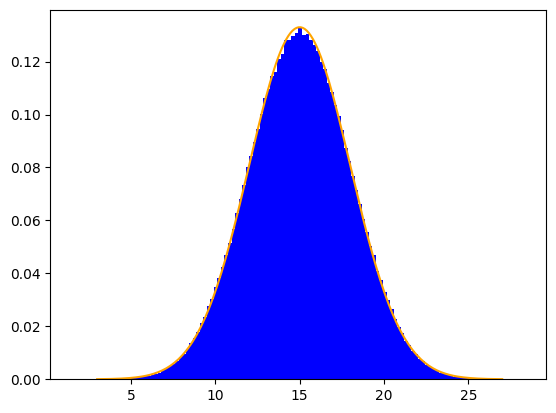

In [4]:
def gen_normal_distribution_from_uniform(mean, std, n=1):
    uniform = np.random.uniform(-1, 1, 12*n)
    samples = []
    for i in range(n):
        batch = uniform[12*i:12*(i+1)]
        sample = 0.5 * np.sum(batch)
        samples.append(sample)
    return np.array(samples, dtype=float).reshape(-1) * std + mean

samples_uniform = gen_normal_distribution_from_uniform(desired_mean, desired_std, n)

mean = np.round(np.mean(samples_uniform), 3)
std = np.round(np.std(samples_uniform), 3)

print(f'mean = {mean}; std = {std}\ndesired_mean = {desired_mean}; desired_std = {desired_std}')

plt.hist(samples_uniform, bins=128, density=True, color='b')
plt.plot(x, normal, color='orange')
plt.show()

## 1.2 Генерация нормального распределения с помощью Rejection-Sampling

mean = 14.999; std = 3.0
desired_mean = 15; desired_std = 3


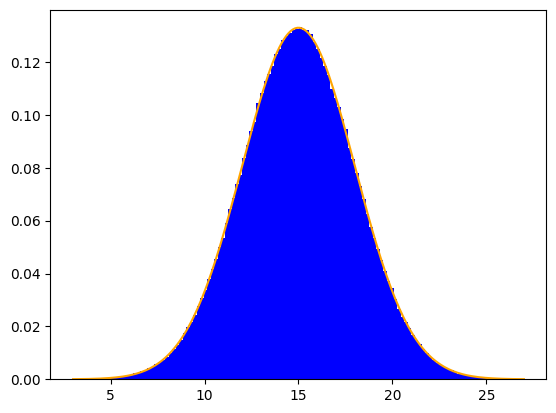

In [5]:
def gen_normal_distribution_rejection(mean, std, n=1):
    k1 = mean - 4 * std
    k2 = mean + 4 * std

    f_max = normal_distribution(mean, mean, std)

    samples = []

    while len(samples) < n:
        x = np.random.uniform(k1, k2, 1)
        u = np.random.uniform(0, f_max, 1)
        if u < normal_distribution(x, mean, std):
            samples.append(x)

    return np.array(samples, dtype=float).reshape(-1, 1)

samples_rejection = gen_normal_distribution_rejection(desired_mean, desired_std, n)

mean = np.round(np.mean(samples_rejection), 3)
std = np.round(np.std(samples_rejection), 3)

print(f'mean = {mean}; std = {std}\ndesired_mean = {desired_mean}; desired_std = {desired_std}')

plt.hist(samples_rejection, bins=128, density=True, color='b')
plt.plot(x, normal, color='orange')
plt.show()

## 1.3 Генерация нормального распределения с помощью преобразования Бокса-Мюллера

mean = 15.003; std = 3.004
desired_mean = 15; std = 3


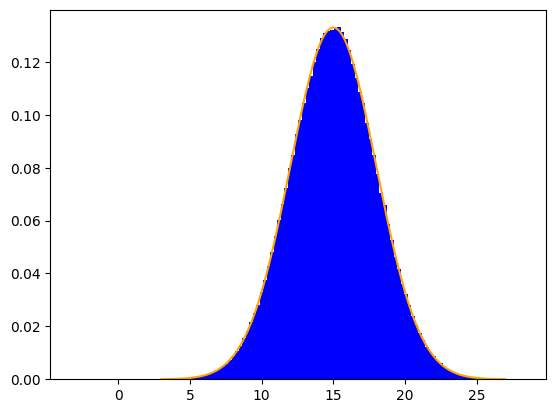

In [6]:
def gen_normal_distribution_box_muller(mean, std, n=1):
    u1 = np.random.uniform(0, 1, n)
    u2 = np.random.uniform(0, 1, n)
    samples = np.cos(2*np.pi*u1) * np.sqrt(-2 * np.log(u2))
    return samples * std + mean

samples_box_muller = gen_normal_distribution_box_muller(desired_mean, desired_std, n)

mean = np.round(np.mean(samples_box_muller), 3)
std = np.round(np.std(samples_box_muller), 3)

print(f'mean = {mean}; std = {std}\ndesired_mean = {desired_mean}; std = {desired_std}')

plt.hist(samples_box_muller, bins=128, density=True, color='b')
plt.plot(x, normal, color='orange')
plt.show()

## 1.4 Сравнение скорости работы

In [7]:
t_uniform = timeit.timeit("gen_normal_distribution_from_uniform(desired_mean, desired_std, n)", globals=globals(), number=1)
t_rejection = timeit.timeit("gen_normal_distribution_rejection(desired_mean, desired_std, n)", globals=globals(), number=1)
t_box = timeit.timeit("gen_normal_distribution_box_muller(desired_mean, desired_std, n)", globals=globals(), number=1)
t_np = timeit.timeit("np.random.normal(loc=desired_mean, scale=desired_std, size=n)", globals=globals(), number=1)
print(f't_uniform = {t_uniform}')
print(f't_rejection = {t_rejection}')
print(f't_box = {t_box}')
print(f't_np = {t_np}')

t_uniform = 1.527883439004654
t_rejection = 17.12186221099546
t_box = 0.020976605999749154
t_np = 0.012116486999730114


## 2 Модель процесса на основе одометрии

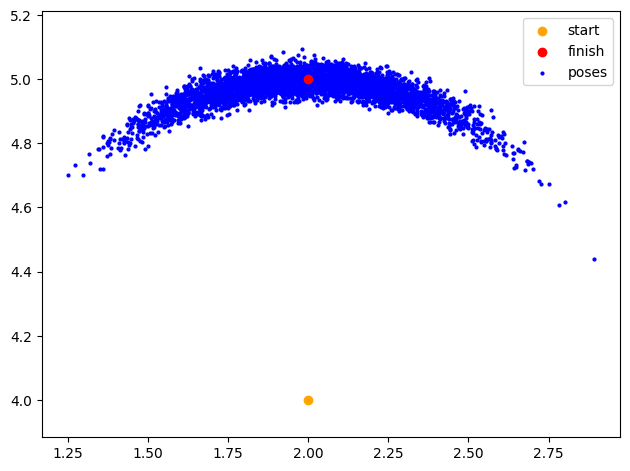

In [8]:
def odometry(X, u, alpha):
    x, y, theta = X.flatten()
    dr1, dr2, dt = u.flatten()
    a1, a2, a3, a4 = alpha.flatten()
    disp_rot_1 = a1 * np.abs(dr1) + a2 * dt
    disp_rot_2 = a1 * np.abs(dr2) + a2 * dt
    disp_tran = a3 * dt + a4 * (np.abs(dr1) + np.abs(dr2))

    dr1_noised = dr1 + gen_normal_distribution_box_muller(0, disp_rot_1)
    dr2_noised = dr2 + gen_normal_distribution_box_muller(0, disp_rot_2)
    dt_noised = dt + gen_normal_distribution_box_muller(0, disp_tran)

    x_n = x + dt_noised * np.cos(theta + dr1_noised)
    y_n = y + dt_noised * np.sin(theta + dr1_noised)
    theta_n = theta + dr1_noised + dr2_noised

    return np.array([x_n, y_n, theta_n]).reshape(-1, 1)

x = np.array([2, 4, 0]).reshape(-1, 1)
u = np.array([np.pi/2, 0, 1]).reshape(-1, 1)
alpha = np.array([0.1, 0.1, 0.01, 0.01]).reshape(-1, 1)

x_new = odometry(x, u, np.zeros_like(alpha))

xarr = []

for _ in range(5000):
    xarr.append(odometry(x, u, alpha))

xarr = np.array(xarr).squeeze(-1)

plt.scatter(x[0, 0], x[1, 0], color='orange', label='start', zorder=2)
plt.scatter(x_new[0, 0], x_new[1, 0], color='red', label='finish', zorder=2)
plt.scatter(xarr[:, 0], xarr[:, 1], s=4, color='b', label='poses', zorder=1)
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()